## Path Settings

In [1]:
pred_dir = r'/home/yutongx/3DUNet/final_results/checkpoint_4/'
gt_dir = r'/home/yxy/disk/data/RibFrac/labels/val'

## Load `.nii.gz`

In [2]:
import os
import nibabel as nib
import numpy as np

class NiiDataSet:
    """
    A dataloder reading all .nii files under one directory.
    Parameters
    ----------
    root_dir : str
        The directory where all .nii files reside.
    """
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.file_list = sorted([os.path.join(root_dir, x)
            for x in os.listdir(root_dir) if x.endswith(".nii.gz")])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        array = nib.load(self.file_list[idx]).get_fdata()

        return array

## Evaluation 

In [3]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage.measure import label, regionprops
from sklearn.metrics import auc
from tqdm import tqdm


__all__ = ["froc", "plot_froc", "evaluate"]


def _compile_pred_metrics(iou_matrix, inter_matrix, pred, pred_label):
    """
    Compile prediction metrics into a Pandas DataFrame
    Parameters
    ----------
    iou_matrix : numpy.ndarray
        IoU array with shape of (n_pred, n_gt).
    inter_matrix : numpy.ndarray
        Intersection array with shape of (n_pred, n_gt).
    pred : numpy.ndarray
        A numpy array of probability prediction for each voxel.
    pred_label : numpy.ndarray
        A numpy array containing n GTs labelled from 1 to n.
    Returns
    -------
    pred_metrics : pandas.DataFrame
        A dataframe of prediction metrics.
    """
    # meanings of each column:
    # pred_label --  The index of prediction
    # max_iou -- The highest IoU this prediction has with any certain GT
    # hit_label -- The GT label with which this prediction has the highest IoU
    # intersect_vox -- Number of voxels contained in the intersection between
    #     this prediction and its hit GT
    # prob -- The confidence prediction of this prediction
    # vol -- This prediction's volume in pixels
    # z, y, x -- Coordinates of this prediction's centroid
    # num_gt -- Total number of GT in this volume
        
    pred_metrics = pd.DataFrame(np.zeros((iou_matrix.shape[0], 9)),
        columns=["pred_label", "max_iou", "hit_label", "intersect_vox",
        "prob", "vol", "z", "y", "x"]) 
    pred_metrics["pred_label"] = np.arange(1, iou_matrix.shape[0] + 1)
    if (iou_matrix.shape[1] == 0) or (iou_matrix.shape[0] == 0): 
        # Exception handling, which does not exists in origin evaluation code
        pred_metrics = pd.DataFrame(np.zeros((iou_matrix.shape[0], 10)),
            columns=["pred_label", "max_iou", "hit_label", "intersect_vox",
            "prob", "vol", "z", "y", "x", "num_gt"]) 
        return pred_metrics
    pred_metrics["max_iou"] = iou_matrix.max(axis=1)
    pred_metrics["hit_label"] = iou_matrix.argmax(axis=1) + 1
    pred_metrics["intersect_vox"] = np.choose(iou_matrix.argmax(axis=1),
        inter_matrix.T)
    # if max_iou == 0, this prediction doesn't hit any GT
    pred_metrics["hit_label"] = pred_metrics.apply(lambda x: x["hit_label"]
        if x["max_iou"] > 0 else 0, axis=1)
    region_props = regionprops(pred_label, pred)
    pred_metrics["prob"] = [prop.mean_intensity for prop in region_props]
    pred_metrics["vol"] = [prop.area for prop in region_props]
    pred_metrics[["z", "y", "x"]] = np.array([prop.centroid
        for prop in region_props])
    pred_metrics["num_gt"] = iou_matrix.shape[1]

    return pred_metrics


def evaluate_single_prediction(pred, gt_label, threshold):
    """
    Evaluate a single prediction.
    Parameters
    ----------
    pred : numpy.ndarray
        The numpy array of prediction.
    gt_label : numpy.ndarray
        The numpy array of ground-truth.
    threshold : float
        If a voxel's prediction probability is higher than threshold,
        it is treated as a positive prediction
    Returns
    -------
    pred_metrics : pandas.DataFrame
        A dataframe of prediction metrics.
    """
    assert pred.shape == gt_label.shape,\
        "The prediction and ground-truth have different shapes. pred:"\
        f" {pred.shape} and gt: {gt_label.shape}."

    gt_label = gt_label.astype(int)
    gt_bin = gt_label > 0

    # Label connected regions
    pred_bin = pred > threshold
    pred_label = label(pred_bin)
    
    num_gt = int(gt_label.max())
    num_pred = int(pred_label.max())
    
    print('instance level--', 'number of groud truth: ', num_gt, 'number of prediction: ',num_pred)
    
    iou_matrix = np.zeros((num_gt, num_pred))
    inter_matrix = np.zeros_like(iou_matrix)

    intersection = np.logical_and(gt_bin, pred_bin)
    union = label(np.logical_or(gt_bin, pred_bin))
    
    #print('label(intersection):', np.where(intersection!=0))
    for region in regionprops(label(intersection)):
        centroid = tuple([int(round(x)) for x in region.centroid])
        gt_idx = gt_label[centroid[0], centroid[1], centroid[2]]
        pred_idx = pred_label[centroid[0], centroid[1], centroid[2]]
        union_idx = union[centroid[0], centroid[1], centroid[2]]
        #print(gt_idx, pred_idx, union_idx)
        if gt_idx == 0 or pred_idx == 0 or union_idx == 0:
            continue
        inter_area = region.area
        union_area = (union == union_idx).sum()
        #print(inter_area, union_area)
        iou = inter_area / (union_area + 1e-8)
        iou_matrix[gt_idx - 1, pred_idx - 1] = iou
        inter_matrix[gt_idx - 1, pred_idx - 1] = inter_area

    iou_matrix = iou_matrix.T
    inter_matrix = inter_matrix.T
        
    pred_metrics = _compile_pred_metrics(iou_matrix, inter_matrix, pred,
        pred_label)
    #print(pred_metrics)
    return pred_metrics


def _froc_single_thresh(df_list, p_thresh, iou_thresh):
    """
    Calculate the FROC for a single confidence threshold.
    Parameters
    ----------
    df_list : list of pandas.DataFrame
        List of Pandas DataFrame of prediction metrics.
    p_thresh : float
        The probability threshold of positive predictions.
    iou_thresh : float
        The IoU threshold of predictions being considered as "hit".
    Returns
    -------
    fpr : float
        False positive rate for this threshold.
    recall : float
        Recall rate for this threshold.
    """
    EPS = 1e-8

    total_gt = total_tp = total_fp = 0
    for df in df_list:
        if len(df) != 0:
            gt_cnt = df["num_gt"][0]
            df = df[df["prob"] >= p_thresh]
            tp_cnt = len(df.loc[df["max_iou"] > iou_thresh,
                "hit_label"].unique())
            fp_cnt = len(df) - len(df.loc[df["max_iou"] > iou_thresh])

            total_gt += gt_cnt
            total_tp += tp_cnt
            total_fp += fp_cnt

    fpr = total_fp / (len(df_list) + EPS)
    recall = total_tp / (total_gt + EPS)

    return fpr, recall


def froc(df_list, iou_thresh=0.1):
    """
    Calculate the FROC curve.
    Parameters
    df_list : list of pandas.DataFrame
        List of prediction metrics.
    iou_thresh : float
        The IoU threshold of predictions being considered as "hit".
    Returns
    -------
    fpr : list of float
        List of false positive rate for a range of threshold from 0 to 1.
    recall : float
        List of recall rate for a range of threshold from 0 to 1.
    aufroc : float
        Area under FROC curve. Range from 0 to 1.
    """
    fpr_recall = [_froc_single_thresh(df_list, p_thresh, iou_thresh)
        for p_thresh in np.arange(0, 1, 0.01)]
    fpr = [x[0] for x in fpr_recall]
    recall = [x[1] for x in fpr_recall]
    aufroc = auc(fpr, recall) / max(fpr)

    return fpr, recall, aufroc


def plot_froc(fpr, recall, aufroc):
    """
    Plot the FROC curve.
    Parameters
    ----------
    fpr : list of float
        List of false positive rates at different confidence thresholds.
    recall : list of float
        List of recall at different confidence thresholds.
    """
    _, ax = plt.subplots()
    ax.plot(fpr, recall)
    ax.set_title("FROC")
    ax.legend([f"AUFROC={aufroc:.4f}"])
    plt.show()


def evaluate(pred_dir, gt_dir, threshold=0.5):
    """
    Evaluate predictions against the ground-truth on a certain subset.
    Parameters
    ----------
    pred_dir : str
        The directory where all prediction .nii files exist.
    subset : str, {"train", "val"}
        Data subset for evaluation.
    threshold : float
        The probability threshold of a positive prediction.
    Returns
    -------
    eval_results : list of pandas.DataFrame
        Evaluation results for each prediction.
    fpr : list of float
        List of false positive rate for a range of threshold from 0 to 1.
    recall : float
        List of recall rate for a range of threshold from 0 to 1.
    aufroc : float
        Area under FROC curve. Range from 0 to 1.
    """
    pred_iter = NiiDataSet(pred_dir)
    gt_iter = NiiDataSet(gt_dir)

    assert len(pred_iter) == len(gt_iter),\
        "Unequal number of predictions and ground-truths."

    eval_results = []
    for i in tqdm(range(len(gt_iter))):
        print('pixel level--', 'ground truth:', np.count_nonzero(gt_iter[i]),
              'pred:', len(pred_iter[i][np.where(pred_iter[i]>threshold)]))
        eval_results.append(evaluate_single_prediction(pred_iter[i],
            gt_iter[i], threshold))
    fpr, recall, aufroc = froc(eval_results)
    plot_froc(fpr, recall, aufroc)

    return eval_results, fpr, recall, aufroc


#if __name__ == "__main__":
#     import argparse


#     parser = argparse.ArgumentParser()
#     parser.add_argument("--pred_dir", required=True)
#     parser.add_argument("--gt_dir", required=True)
#     args = parser.parse_args()

#     _, _, _, aufroc = evaluate(args.pred_dir, args.gt_dir)
#     print(f"Evaluation on {args.subset}: AUFROC={aufroc:.4f}")

  0%|          | 0/80 [00:00<?, ?it/s]

pixel level-- ground truth: 11466 pred: 0
instance level-- number of groud truth:  4 number of prediction:  0


  1%|▏         | 1/80 [00:22<30:07, 22.88s/it]

pixel level-- ground truth: 26008 pred: 0
instance level-- number of groud truth:  6 number of prediction:  0


  2%|▎         | 2/80 [00:44<29:20, 22.58s/it]

pixel level-- ground truth: 8061 pred: 0
instance level-- number of groud truth:  4 number of prediction:  0


  4%|▍         | 3/80 [01:09<29:58, 23.36s/it]

pixel level-- ground truth: 25356 pred: 0
instance level-- number of groud truth:  8 number of prediction:  0


  5%|▌         | 4/80 [01:38<31:25, 24.81s/it]

pixel level-- ground truth: 17996 pred: 0
instance level-- number of groud truth:  6 number of prediction:  0


  6%|▋         | 5/80 [02:03<31:07, 24.90s/it]

pixel level-- ground truth: 18735 pred: 0
instance level-- number of groud truth:  3 number of prediction:  0


  8%|▊         | 6/80 [02:35<33:33, 27.21s/it]

pixel level-- ground truth: 57396 pred: 0
instance level-- number of groud truth:  9 number of prediction:  0


  9%|▉         | 7/80 [03:00<32:20, 26.59s/it]

pixel level-- ground truth: 34033 pred: 204
instance level-- number of groud truth:  8 number of prediction:  1


 10%|█         | 8/80 [03:27<31:53, 26.58s/it]

pixel level-- ground truth: 25321 pred: 0
instance level-- number of groud truth:  10 number of prediction:  0


 11%|█▏        | 9/80 [03:49<29:40, 25.07s/it]

pixel level-- ground truth: 2232 pred: 0
instance level-- number of groud truth:  1 number of prediction:  0


 12%|█▎        | 10/80 [04:13<29:04, 24.92s/it]

pixel level-- ground truth: 17471 pred: 0
instance level-- number of groud truth:  5 number of prediction:  0


 14%|█▍        | 11/80 [04:39<28:55, 25.15s/it]

pixel level-- ground truth: 11572 pred: 0
instance level-- number of groud truth:  6 number of prediction:  0


 15%|█▌        | 12/80 [04:58<26:37, 23.49s/it]

pixel level-- ground truth: 133896 pred: 0
instance level-- number of groud truth:  16 number of prediction:  0


 16%|█▋        | 13/80 [05:24<26:52, 24.07s/it]

pixel level-- ground truth: 5767 pred: 0
instance level-- number of groud truth:  4 number of prediction:  0


 18%|█▊        | 14/80 [05:46<25:48, 23.46s/it]

pixel level-- ground truth: 0 pred: 0
instance level-- number of groud truth:  0 number of prediction:  0


 19%|█▉        | 15/80 [05:58<21:44, 20.07s/it]

pixel level-- ground truth: 27611 pred: 1460
instance level-- number of groud truth:  13 number of prediction:  1


 20%|██        | 16/80 [06:20<21:58, 20.60s/it]

pixel level-- ground truth: 66921 pred: 780
instance level-- number of groud truth:  10 number of prediction:  2


 21%|██▏       | 17/80 [06:47<23:41, 22.56s/it]

pixel level-- ground truth: 19206 pred: 0
instance level-- number of groud truth:  7 number of prediction:  0


 22%|██▎       | 18/80 [07:15<24:57, 24.15s/it]

pixel level-- ground truth: 0 pred: 0
instance level-- number of groud truth:  0 number of prediction:  0


 24%|██▍       | 19/80 [07:27<20:48, 20.47s/it]

pixel level-- ground truth: 6085 pred: 0
instance level-- number of groud truth:  4 number of prediction:  0


 25%|██▌       | 20/80 [07:53<22:12, 22.20s/it]

pixel level-- ground truth: 24915 pred: 0
instance level-- number of groud truth:  9 number of prediction:  0


 26%|██▋       | 21/80 [08:17<22:19, 22.70s/it]

pixel level-- ground truth: 0 pred: 0
instance level-- number of groud truth:  0 number of prediction:  0


 28%|██▊       | 22/80 [08:31<19:27, 20.12s/it]

pixel level-- ground truth: 21446 pred: 0
instance level-- number of groud truth:  6 number of prediction:  0


 29%|██▉       | 23/80 [09:00<21:29, 22.63s/it]

pixel level-- ground truth: 15664 pred: 0
instance level-- number of groud truth:  8 number of prediction:  0


 30%|███       | 24/80 [09:23<21:27, 22.99s/it]

pixel level-- ground truth: 176380 pred: 0
instance level-- number of groud truth:  19 number of prediction:  0


 31%|███▏      | 25/80 [09:47<21:20, 23.27s/it]

pixel level-- ground truth: 0 pred: 0
instance level-- number of groud truth:  0 number of prediction:  0


 32%|███▎      | 26/80 [10:03<19:00, 21.12s/it]

pixel level-- ground truth: 106664 pred: 0
instance level-- number of groud truth:  14 number of prediction:  0


 34%|███▍      | 27/80 [10:32<20:32, 23.26s/it]

pixel level-- ground truth: 0 pred: 0
instance level-- number of groud truth:  0 number of prediction:  0


 35%|███▌      | 28/80 [10:40<16:11, 18.68s/it]

pixel level-- ground truth: 16944 pred: 0
instance level-- number of groud truth:  3 number of prediction:  0


 36%|███▋      | 29/80 [11:10<18:52, 22.20s/it]

pixel level-- ground truth: 2997 pred: 1616
instance level-- number of groud truth:  1 number of prediction:  1


 38%|███▊      | 30/80 [11:34<19:02, 22.85s/it]

pixel level-- ground truth: 15375 pred: 0
instance level-- number of groud truth:  4 number of prediction:  0


 39%|███▉      | 31/80 [11:59<19:00, 23.27s/it]

pixel level-- ground truth: 0 pred: 0
instance level-- number of groud truth:  0 number of prediction:  0


 40%|████      | 32/80 [12:04<14:18, 17.89s/it]

pixel level-- ground truth: 0 pred: 0
instance level-- number of groud truth:  0 number of prediction:  0


 41%|████▏     | 33/80 [12:21<13:50, 17.68s/it]

pixel level-- ground truth: 0 pred: 0
instance level-- number of groud truth:  0 number of prediction:  0


 42%|████▎     | 34/80 [12:35<12:43, 16.60s/it]

pixel level-- ground truth: 31229 pred: 0
instance level-- number of groud truth:  7 number of prediction:  0


 44%|████▍     | 35/80 [13:05<15:17, 20.40s/it]

pixel level-- ground truth: 0 pred: 0
instance level-- number of groud truth:  0 number of prediction:  0


 45%|████▌     | 36/80 [13:28<15:32, 21.19s/it]

pixel level-- ground truth: 28054 pred: 0
instance level-- number of groud truth:  6 number of prediction:  0


 46%|████▋     | 37/80 [13:54<16:20, 22.80s/it]

pixel level-- ground truth: 43746 pred: 0
instance level-- number of groud truth:  12 number of prediction:  0


 48%|████▊     | 38/80 [14:19<16:22, 23.38s/it]

pixel level-- ground truth: 73231 pred: 20096
instance level-- number of groud truth:  2 number of prediction:  5


 49%|████▉     | 39/80 [14:42<15:57, 23.37s/it]

pixel level-- ground truth: 95259 pred: 4812
instance level-- number of groud truth:  6 number of prediction:  3


 50%|█████     | 40/80 [15:11<16:38, 24.95s/it]

pixel level-- ground truth: 0 pred: 0
instance level-- number of groud truth:  0 number of prediction:  0


 51%|█████▏    | 41/80 [15:18<12:41, 19.53s/it]

pixel level-- ground truth: 0 pred: 0
instance level-- number of groud truth:  0 number of prediction:  0


 52%|█████▎    | 42/80 [15:20<09:06, 14.37s/it]

pixel level-- ground truth: 122773 pred: 4076
instance level-- number of groud truth:  10 number of prediction:  11


 54%|█████▍    | 43/80 [15:40<09:58, 16.18s/it]

pixel level-- ground truth: 7765 pred: 4748
instance level-- number of groud truth:  5 number of prediction:  4


 55%|█████▌    | 44/80 [16:08<11:44, 19.56s/it]

pixel level-- ground truth: 39085 pred: 0
instance level-- number of groud truth:  7 number of prediction:  0


 56%|█████▋    | 45/80 [16:26<11:11, 19.18s/it]

pixel level-- ground truth: 48035 pred: 0
instance level-- number of groud truth:  6 number of prediction:  0


 57%|█████▊    | 46/80 [16:51<11:53, 20.99s/it]

pixel level-- ground truth: 21969 pred: 500
instance level-- number of groud truth:  7 number of prediction:  1


 59%|█████▉    | 47/80 [17:23<13:20, 24.27s/it]

pixel level-- ground truth: 973 pred: 0
instance level-- number of groud truth:  1 number of prediction:  0


 60%|██████    | 48/80 [17:43<12:17, 23.05s/it]

pixel level-- ground truth: 16686 pred: 1084
instance level-- number of groud truth:  6 number of prediction:  2


 61%|██████▏   | 49/80 [18:13<12:54, 24.97s/it]

pixel level-- ground truth: 0 pred: 0
instance level-- number of groud truth:  0 number of prediction:  0


 62%|██████▎   | 50/80 [18:32<11:38, 23.30s/it]

pixel level-- ground truth: 0 pred: 0
instance level-- number of groud truth:  0 number of prediction:  0


 64%|██████▍   | 51/80 [18:38<08:43, 18.06s/it]

pixel level-- ground truth: 0 pred: 0
instance level-- number of groud truth:  0 number of prediction:  0


 65%|██████▌   | 52/80 [18:53<07:56, 17.03s/it]

pixel level-- ground truth: 14178 pred: 0
instance level-- number of groud truth:  5 number of prediction:  0


 66%|██████▋   | 53/80 [19:16<08:33, 19.00s/it]

pixel level-- ground truth: 0 pred: 0
instance level-- number of groud truth:  0 number of prediction:  0


 68%|██████▊   | 54/80 [19:21<06:19, 14.61s/it]

pixel level-- ground truth: 0 pred: 0
instance level-- number of groud truth:  0 number of prediction:  0


 69%|██████▉   | 55/80 [19:33<05:50, 14.03s/it]

pixel level-- ground truth: 10096 pred: 0
instance level-- number of groud truth:  5 number of prediction:  0


 70%|███████   | 56/80 [20:00<07:03, 17.65s/it]

pixel level-- ground truth: 12161 pred: 0
instance level-- number of groud truth:  7 number of prediction:  0


 71%|███████▏  | 57/80 [20:22<07:17, 19.01s/it]

pixel level-- ground truth: 16591 pred: 0
instance level-- number of groud truth:  6 number of prediction:  0


 72%|███████▎  | 58/80 [21:10<10:08, 27.68s/it]

pixel level-- ground truth: 30836 pred: 0
instance level-- number of groud truth:  5 number of prediction:  0


 74%|███████▍  | 59/80 [21:33<09:11, 26.25s/it]

pixel level-- ground truth: 66624 pred: 0
instance level-- number of groud truth:  18 number of prediction:  0


 75%|███████▌  | 60/80 [22:00<08:51, 26.55s/it]

pixel level-- ground truth: 17914 pred: 0
instance level-- number of groud truth:  5 number of prediction:  0


 76%|███████▋  | 61/80 [22:27<08:29, 26.79s/it]

pixel level-- ground truth: 20200 pred: 4620
instance level-- number of groud truth:  6 number of prediction:  3


 78%|███████▊  | 62/80 [22:55<08:07, 27.08s/it]

pixel level-- ground truth: 41360 pred: 0
instance level-- number of groud truth:  8 number of prediction:  0


 79%|███████▉  | 63/80 [23:20<07:30, 26.51s/it]

pixel level-- ground truth: 59273 pred: 0
instance level-- number of groud truth:  11 number of prediction:  0


 80%|████████  | 64/80 [23:46<06:59, 26.22s/it]

pixel level-- ground truth: 0 pred: 0
instance level-- number of groud truth:  0 number of prediction:  0


 81%|████████▏ | 65/80 [23:53<05:08, 20.54s/it]

pixel level-- ground truth: 135212 pred: 0
instance level-- number of groud truth:  13 number of prediction:  0


 82%|████████▎ | 66/80 [24:22<05:21, 22.99s/it]

pixel level-- ground truth: 0 pred: 0
instance level-- number of groud truth:  0 number of prediction:  0


 84%|████████▍ | 67/80 [24:25<03:41, 17.06s/it]

pixel level-- ground truth: 12594 pred: 8884
instance level-- number of groud truth:  3 number of prediction:  3


 85%|████████▌ | 68/80 [24:47<03:43, 18.65s/it]

pixel level-- ground truth: 25443 pred: 0
instance level-- number of groud truth:  8 number of prediction:  0


 86%|████████▋ | 69/80 [25:17<04:02, 22.05s/it]

pixel level-- ground truth: 0 pred: 0
instance level-- number of groud truth:  0 number of prediction:  0


 88%|████████▊ | 70/80 [25:24<02:53, 17.39s/it]

pixel level-- ground truth: 0 pred: 0
instance level-- number of groud truth:  0 number of prediction:  0


 89%|████████▉ | 71/80 [25:38<02:26, 16.32s/it]

pixel level-- ground truth: 29134 pred: 2800
instance level-- number of groud truth:  6 number of prediction:  2


 90%|█████████ | 72/80 [26:09<02:46, 20.85s/it]

pixel level-- ground truth: 116481 pred: 18524
instance level-- number of groud truth:  19 number of prediction:  5


 91%|█████████▏| 73/80 [26:34<02:34, 22.09s/it]

pixel level-- ground truth: 13833 pred: 0
instance level-- number of groud truth:  12 number of prediction:  0


 92%|█████████▎| 74/80 [26:52<02:05, 20.94s/it]

pixel level-- ground truth: 32423 pred: 0
instance level-- number of groud truth:  6 number of prediction:  0


 94%|█████████▍| 75/80 [27:15<01:47, 21.44s/it]

pixel level-- ground truth: 9594 pred: 144
instance level-- number of groud truth:  3 number of prediction:  1


 95%|█████████▌| 76/80 [27:39<01:29, 22.38s/it]

pixel level-- ground truth: 32913 pred: 0
instance level-- number of groud truth:  12 number of prediction:  0


 96%|█████████▋| 77/80 [27:54<01:00, 20.18s/it]

pixel level-- ground truth: 12690 pred: 0
instance level-- number of groud truth:  5 number of prediction:  0


 98%|█████████▊| 78/80 [28:25<00:46, 23.32s/it]

pixel level-- ground truth: 29676 pred: 0
instance level-- number of groud truth:  3 number of prediction:  0


 99%|█████████▉| 79/80 [28:53<00:24, 24.61s/it]

pixel level-- ground truth: 19056 pred: 0
instance level-- number of groud truth:  6 number of prediction:  0


100%|██████████| 80/80 [29:26<00:00, 22.08s/it]


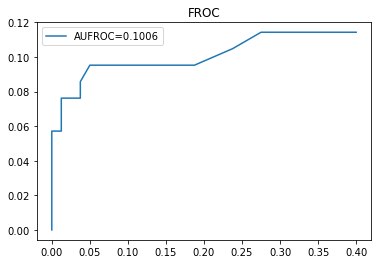

Evaluation on /home/yutongx/3DUNet/final_results/checkpoint_4/: AUFROC=0.1006


In [4]:
_, fpr, recall, aufroc = evaluate(pred_dir, gt_dir)

print(f"Evaluation on {pred_dir}: AUFROC={aufroc:.4f}")